## Adapter Tuning
- 引入少量可训练参数的Adapter模块，实现快速且高效的微调，无需对原始模型的大量参数进行更新。
- 通常将小型的全连接层放置在Transformer层中的各个子层之间，独立学习不同任务的特征，进而实现模型适应新的任务需求。

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertModel, BertTokenizer
from transformers.modeling_outputs import BaseModelOutputWithPastAndCrossAttentions

In [18]:
# Adapter模块的定义
class Adapter(nn.Module):
    def __init__(self, input_dim, bottleneck_dim=64):
        """
        Arg:
            input_dim: 输入特征的维度
            bottleneck_dim: 瓶颈层的维度，通常远小于input_dim
        """
        super(Adapter, self).__init__()
        self.down_proj = nn.Linear(input_dim, bottleneck_dim)
        self.up_proj = nn.Linear(bottleneck_dim, input_dim)
        self.activation = nn.ReLU()

    def forward(self, x):
        down = self.down_proj(x)
        activated = self.activation(down)
        up = self.up_proj(activated)
        return x + up  # 残差连接，使模型更稳定

In [19]:
# Transformer层集成Adapter （伪实现）
class BertWithAdapterFake(nn.Module):
    def __init__(self, adapter_dim=64, num_labels=2, pretrained_model_name='../bert-base-uncased'):
        """
        Arg:
            adapter_dim: Adapter模块中瓶颈层的维度
            num_labels: 分类任务的标签数量
            pretrained_model_name: 预训练模型的路径或名称
        """
        super(BertWithAdapterFake, self).__init__()
        self.bert = BertModel.from_pretrained(pretrained_model_name)
        self.adapter_layers = nn.ModuleList([
            Adapter(self.bert.config.hidden_size, adapter_dim)
            for _ in range(self.bert.config.num_hidden_layers)
        ])
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask=None):
        """
        Arg:
            input_ids: 输入的token IDs
            attention_mask: 注意力掩码
        Return:
            最后一层Transformer的输出，经过Adapter模块调整后的结果
        """
        outputs = self.bert(input_ids, attention_mask=attention_mask, output_hidden_states=True)
        hidden_states = list(outputs.hidden_states)  # 获取所有层的隐藏状态
        # 在每个Transformer层后应用Adapter
        for i, adapter in enumerate(self.adapter_layers):
            hidden_states[i + 1] = adapter(hidden_states[i + 1])  # BERT原模型的每层的输出已经有了，将第一层的输出传给第一个Adapter，以此类推
        return hidden_states[-1]

In [20]:
class BertLayerWithAdapter(nn.Module):
    def __init__(self, bert_layer, adapter):
        super().__init__()
        self.layer = bert_layer
        self.adapter = adapter

    def forward(self, hidden_states, *args, **kwargs):
        # 调用原始 BertLayer
        output = self.layer(hidden_states, *args, **kwargs)
        # BertLayer 返回的是 hidden_states（不是 tuple）
        hidden_states = output
        # Adapter
        hidden_states = self.adapter(hidden_states)
        return hidden_states


# 主模型：正确集成 Adapter
class BertWithAdapter(nn.Module):
    def __init__(self, adapter_dim=64, num_labels=2, pretrained_model_name='../bert-base-uncased'):
        super().__init__()

        self.bert = BertModel.from_pretrained(pretrained_model_name)
        # 冻结 BERT
        for param in self.bert.parameters():
            param.requires_grad = False
        # Adapter
        self.adapter_layers = nn.ModuleList()
        for i in range(self.bert.config.num_hidden_layers):
            adapter = Adapter(
                input_dim=self.bert.config.hidden_size,
                bottleneck_dim=adapter_dim
            )
            self.adapter_layers.append(adapter)
            self.bert.encoder.layer[i] = BertLayerWithAdapter(
                self.bert.encoder.layer[i],
                adapter
            )
        # 分类头（可训练）
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask=None):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        # [CLS] 向量
        cls_embedding = outputs.last_hidden_state[:, 0]
        logits = self.classifier(cls_embedding)
        return logits

In [21]:
# 加载bert分词器
tokenizer = BertTokenizer.from_pretrained('../bert-base-uncased')

In [22]:
# 模拟数据加载
def prepare_data(sentences, labels, tokenizer, max_length=128):
    encoding = tokenizer(
        sentences,
        max_length=max_length,
        padding=True,
        truncation=True,
        return_tensors='pt',
        attention_mask=True,
    )
    input_ids = encoding['input_ids']
    attention_mask = encoding['attention_mask']
    labels = torch.tensor(labels)
    return TensorDataset(input_ids, attention_mask, labels)

In [23]:
# 准备示例数据
texts = ["This is a positive example.", "This is a negative example."]
labels = [1, 0]
dataset = prepare_data(texts, labels, tokenizer)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

In [24]:
# 实例化模型与训练组件
criterion = nn.CrossEntropyLoss()

fake_model = BertWithAdapterFake(adapter_dim=64)
optimizer_fake = optim.Adam(fake_model.adapter_layers.parameters(), lr=1e-4)

Loading weights: 100%|██████████| 199/199 [00:00<00:00, 591.06it/s, Materializing param=pooler.dense.weight]                               
BertModel LOAD REPORT from: ../bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [33]:
def train_fake_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss, correct_predictions = 0, 0
    for batch in dataloader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        
        outputs = model(input_ids, attention_mask)
        logits = outputs[:, 0, :]  # 使用[CLS]标记的输出进行分类
        loss = criterion(logits, labels)

        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, pred = torch.max(logits, dim=1)
        correct_predictions += torch.sum(pred == labels).item()
    avg_loss = total_loss / len(dataloader)
    accuracy = correct_predictions / len(dataloader.dataset)
    return avg_loss, accuracy

In [ ]:
# 训练过程
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
fake_model.to(device)
fake_loss_history = []
for epoch in range(300):  # 训练3个epoch
    loss, acc = train_fake_epoch(fake_model, dataloader, criterion, optimizer_fake, device)
    fake_loss_history.append(loss)
    print(f"Epoch {epoch+1}, Loss: {loss:.4f}, Accuracy: {acc:.4f}")

Epoch 1, Loss: 0.6234, Accuracy: 1.0000
Epoch 2, Loss: 0.5275, Accuracy: 1.0000
Epoch 3, Loss: 0.5843, Accuracy: 1.0000
Epoch 4, Loss: 0.6148, Accuracy: 1.0000
Epoch 5, Loss: 0.6921, Accuracy: 0.5000
Epoch 6, Loss: 0.5350, Accuracy: 1.0000
Epoch 7, Loss: 0.6175, Accuracy: 1.0000
Epoch 8, Loss: 0.6375, Accuracy: 0.5000
Epoch 9, Loss: 0.6857, Accuracy: 0.5000
Epoch 10, Loss: 0.6544, Accuracy: 1.0000
Epoch 11, Loss: 0.5396, Accuracy: 1.0000
Epoch 12, Loss: 0.6524, Accuracy: 1.0000
Epoch 13, Loss: 0.6479, Accuracy: 1.0000
Epoch 14, Loss: 0.6369, Accuracy: 0.5000
Epoch 15, Loss: 0.5325, Accuracy: 1.0000
Epoch 16, Loss: 0.6773, Accuracy: 1.0000
Epoch 17, Loss: 0.8017, Accuracy: 0.0000
Epoch 18, Loss: 0.5603, Accuracy: 1.0000
Epoch 19, Loss: 1.0405, Accuracy: 0.5000
Epoch 20, Loss: 0.6261, Accuracy: 0.5000
Epoch 21, Loss: 0.6726, Accuracy: 1.0000
Epoch 22, Loss: 0.6564, Accuracy: 1.0000
Epoch 23, Loss: 0.6006, Accuracy: 1.0000
Epoch 24, Loss: 0.7708, Accuracy: 0.5000
Epoch 25, Loss: 0.6212, A

In [40]:
def plot_loss_curve(loss_history):
    import matplotlib.pyplot as plt

    print("绘制训练损失曲线...", loss_history)
    plt.figure()
    plt.plot(range(1, len(loss_history) + 1), loss_history)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Curve (BERT + Adapter)")
    plt.grid(True)
    plt.show()

绘制训练损失曲线... [0.6233953237533569, 0.52749103307724, 0.58431077003479, 0.6148297786712646, 0.6921095848083496, 0.5350087881088257, 0.6174925565719604, 0.6374591588973999, 0.6857376098632812, 0.6544487476348877, 0.5396153926849365, 0.6523536443710327, 0.6478945016860962, 0.636881947517395, 0.5325231552124023, 0.6773496866226196, 0.80171138048172, 0.5602584481239319, 1.0404912233352661, 0.6261368989944458, 0.6726377010345459, 0.6564220786094666, 0.600637674331665, 0.7708220481872559, 0.6212430000305176, 0.5945538282394409, 0.7184084057807922, 0.6046786904335022, 0.5891683101654053, 0.6174303889274597, 0.6514322757720947, 0.5727964639663696, 0.684099555015564, 0.6720152497291565, 0.5270980596542358, 0.6064361333847046, 0.7339886426925659, 0.7321736812591553, 0.7275882959365845, 0.6623311042785645, 0.581019401550293, 0.5312250852584839, 0.5623877048492432, 0.6253363490104675, 0.6276335716247559, 0.6954659223556519, 0.6094334125518799, 0.6651897430419922, 0.5923965573310852, 0.536441683769226

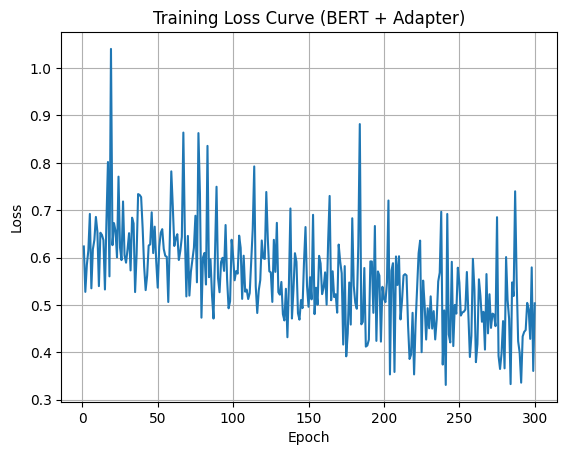

In [ ]:
plot_loss_curve(fake_loss_history)

In [36]:
truth_model = BertWithAdapter(adapter_dim=64)

for name, param in truth_model.named_parameters():
    if param.requires_grad:
        print(f"✅ 可训练: {name} (shape={param.shape})")
    else:
        # 检查是否属于 BERT 主干
        if 'bert' in name and 'adapter' not in name.lower():
            assert not param.requires_grad, f"❌ BERT 参数意外可训练: {name}"

Loading weights: 100%|██████████| 199/199 [00:00<00:00, 488.87it/s, Materializing param=pooler.dense.weight]                               
BertModel LOAD REPORT from: ../bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


✅ 可训练: bert.encoder.layer.0.adapter.down_proj.weight (shape=torch.Size([64, 768]))
✅ 可训练: bert.encoder.layer.0.adapter.down_proj.bias (shape=torch.Size([64]))
✅ 可训练: bert.encoder.layer.0.adapter.up_proj.weight (shape=torch.Size([768, 64]))
✅ 可训练: bert.encoder.layer.0.adapter.up_proj.bias (shape=torch.Size([768]))
✅ 可训练: bert.encoder.layer.1.adapter.down_proj.weight (shape=torch.Size([64, 768]))
✅ 可训练: bert.encoder.layer.1.adapter.down_proj.bias (shape=torch.Size([64]))
✅ 可训练: bert.encoder.layer.1.adapter.up_proj.weight (shape=torch.Size([768, 64]))
✅ 可训练: bert.encoder.layer.1.adapter.up_proj.bias (shape=torch.Size([768]))
✅ 可训练: bert.encoder.layer.2.adapter.down_proj.weight (shape=torch.Size([64, 768]))
✅ 可训练: bert.encoder.layer.2.adapter.down_proj.bias (shape=torch.Size([64]))
✅ 可训练: bert.encoder.layer.2.adapter.up_proj.weight (shape=torch.Size([768, 64]))
✅ 可训练: bert.encoder.layer.2.adapter.up_proj.bias (shape=torch.Size([768]))
✅ 可训练: bert.encoder.layer.3.adapter.down_proj.weight (s

In [ ]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss, correct_predictions = 0, 0
    for batch in dataloader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        
        outputs = model(input_ids, attention_mask)
        logits = outputs
        loss = criterion(logits, labels)

        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, pred = torch.max(logits, dim=1)
        correct_predictions += torch.sum(pred == labels).item()
    avg_loss = total_loss / len(dataloader)
    accuracy = correct_predictions / len(dataloader.dataset)
    return avg_loss, accuracy

# 训练过程
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
truth_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_truth = optim.Adam(truth_model.adapter_layers.parameters(), lr=1e-4)

truth_loss_history = []
for epoch in range(300):  # 训练3个epoch
    loss, acc = train_epoch(truth_model, dataloader, criterion, optimizer_truth, device)
    truth_loss_history.append(loss)
    print(f"Epoch {epoch+1}, Loss: {loss:.4f}, Accuracy: {acc:.4f}")

AttributeError: 'Tensor' object has no attribute 'logits'

绘制训练损失曲线... [0.7538043260574341, 0.6205874681472778, 0.717051088809967, 0.7441102266311646, 0.6629986763000488, 0.6244195103645325, 0.6778182983398438, 0.7018957138061523, 0.7445067167282104, 0.6567820310592651, 0.6894670724868774, 0.59955894947052, 0.7118086814880371, 0.5965009927749634, 0.6953994035720825, 0.5234783887863159, 0.5250381231307983, 0.6348099708557129, 0.6428656578063965, 0.4988919198513031, 0.5407156348228455, 0.5794730186462402, 0.532800555229187, 0.51503586769104, 0.6125110387802124, 0.5773899555206299, 0.5147721767425537, 0.5665009021759033, 0.5983359813690186, 0.5002556443214417, 0.5487892627716064, 0.4821847081184387, 0.5631192326545715, 0.42503392696380615, 0.30724549293518066, 0.274516761302948, 0.37323394417762756, 0.3553614914417267, 0.2984829246997833, 0.25685274600982666, 0.24566879868507385, 0.18319270014762878, 0.13370265066623688, 0.21141211688518524, 0.18671691417694092, 0.14351250231266022, 0.127539724111557, 0.10761711001396179, 0.11831260472536087, 0.0

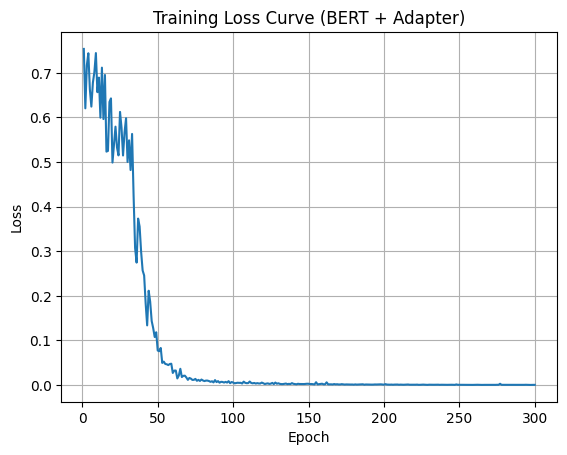

In [42]:
plot_loss_curve(truth_loss_history)

In [48]:
from transformers import BertForSequenceClassification
from peft import get_peft_model, LoraConfig, TaskType

# 1. 加载基础模型
model = BertForSequenceClassification.from_pretrained(
    "../bert-base-uncased",
    num_labels=2
)

# 2. 使用 LoRA 模拟 Adapter（FFN / Output 后）
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8,                  # bottleneck
    lora_alpha=16,
    lora_dropout=0.1,
    target_modules=["dense"],   # 🔑 Adapter 语义
    bias="none",
)

# 3. 注入 PEFT 模块
model = get_peft_model(model, peft_config)

model.print_trainable_parameters()
# trainable params ≈ 0.1%（合理）

model.to(device)

# 4. Optimizer（只更新可训练参数）
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-4
)


def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss, correct_predictions = 0, 0
    for batch in dataloader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        
        outputs = model(input_ids, attention_mask)
        logits = outputs.logits
        loss = criterion(logits, labels)

        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, pred = torch.max(logits, dim=1)
        correct_predictions += torch.sum(pred == labels).item()
    avg_loss = total_loss / len(dataloader)
    accuracy = correct_predictions / len(dataloader.dataset)
    return avg_loss, accuracy

# 5. 正常训练
loss_history = []
for epoch in range(300):
    loss, acc = train_epoch(
        model, dataloader, criterion, optimizer, device
    )
    loss_history.append(loss)
    print(f"Epoch {epoch+1}, Loss: {loss:.4f}, Accuracy: {acc:.4f}")


Loading weights: 100%|██████████| 199/199 [00:00<00:00, 436.74it/s, Materializing param=bert.pooler.dense.weight]                               
BertForSequenceClassification LOAD REPORT from: ../bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those

trainable params: 898,562 || all params: 110,382,340 || trainable%: 0.8140
Epoch 1, Loss: 0.6671, Accuracy: 0.5000
Epoch 2, Loss: 0.7341, Accuracy: 0.5000
Epoch 3, Loss: 0.6281, Accuracy: 1.0000
Epoch 4, Loss: 0.6950, Accuracy: 0.5000
Epoch 5, Loss: 0.8278, Accuracy: 0.0000
Epoch 6, Loss: 0.7822, Accuracy: 0.0000
Epoch 7, Loss: 0.6442, Accuracy: 0.5000
Epoch 8, Loss: 0.8224, Accuracy: 0.0000
Epoch 9, Loss: 0.6981, Accuracy: 0.5000
Epoch 10, Loss: 0.6327, Accuracy: 0.5000
Epoch 11, Loss: 0.7786, Accuracy: 0.0000
Epoch 12, Loss: 0.7059, Accuracy: 0.0000
Epoch 13, Loss: 0.7060, Accuracy: 0.5000
Epoch 14, Loss: 0.5906, Accuracy: 1.0000
Epoch 15, Loss: 0.5752, Accuracy: 1.0000
Epoch 16, Loss: 0.7365, Accuracy: 0.5000
Epoch 17, Loss: 0.6074, Accuracy: 1.0000
Epoch 18, Loss: 0.6537, Accuracy: 1.0000
Epoch 19, Loss: 0.6678, Accuracy: 0.5000
Epoch 20, Loss: 0.6678, Accuracy: 0.5000
Epoch 21, Loss: 0.6979, Accuracy: 0.5000
Epoch 22, Loss: 0.6655, Accuracy: 1.0000
Epoch 23, Loss: 0.6006, Accuracy

绘制训练损失曲线... [0.6670858860015869, 0.7340630292892456, 0.6280959248542786, 0.6949771642684937, 0.827755331993103, 0.7822468280792236, 0.6441735625267029, 0.8223574757575989, 0.69809889793396, 0.6327099800109863, 0.7785518169403076, 0.7059168815612793, 0.7060046792030334, 0.5906436443328857, 0.5751709938049316, 0.7365498542785645, 0.60738205909729, 0.6537328958511353, 0.6678125858306885, 0.6677626967430115, 0.6978828310966492, 0.6654595136642456, 0.6005641222000122, 0.6019785404205322, 0.6933965086936951, 0.6404451131820679, 0.5337114334106445, 0.7030655741691589, 0.6510646343231201, 0.642013669013977, 0.5661695003509521, 0.6214395761489868, 0.6274275779724121, 0.6018193960189819, 0.5850598812103271, 0.5631998181343079, 0.5889085531234741, 0.6882396936416626, 0.6011193990707397, 0.6346097588539124, 0.6351071000099182, 0.4217658042907715, 0.6000872254371643, 0.4065648317337036, 0.3970746099948883, 0.5204646587371826, 0.5189459919929504, 0.475223183631897, 0.24473068118095398, 0.21538802981

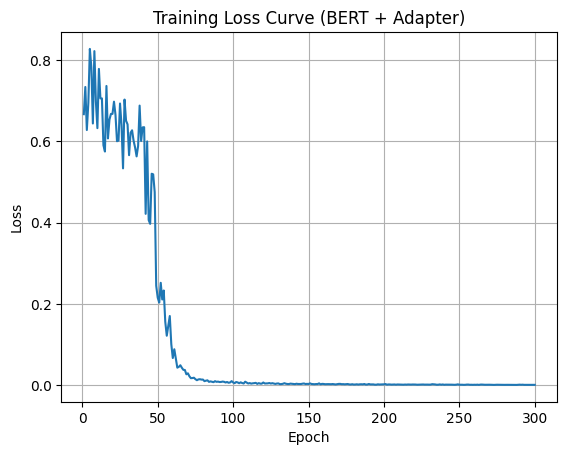

In [49]:
plot_loss_curve(loss_history)